In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 13 09:02:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction
---
The present project consisted in testing some recurrent neural network (RNN) models in order to perform a text classification task. In particular, the models have been trained to associate a prdtypecode (which will be the target feature) to each item present in a e-commerce catalog. The features that have been exploited to perform such task are "**description**" and "**designation**" which contain the name and some additional informations about each item. 

RNNs are designed to make use of sequential data, when the current step has some kind of relation with the previous steps. This makes them ideal for applications with a natural language processing where it's important to consider the order and sequentiality of the words in order to catch their meaning within a given context. 

The notebook is organized as follows:
1. Preprocessing
2. RNN fitting on the raw "text" feature
3. RNN fitting on the clean "text"
4. RNN fitting on clean "text": batch size influence
5. RNN(LSTM) fitting on clean "text"
6. CNN-RNN(LSTM) fitting on clean "text"


# 1. Preprocessing

In [173]:
#-----------------------------------------------------------------------------------------------------------
#import libraries and loading dataset
#-----------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,classification_report
import re
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.tokenize import RegexpTokenizer
import pickle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping

data = pd.read_csv("/content/drive/MyDrive/X_train_update.csv", encoding='utf-8')
target = pd.read_csv("/content/drive/MyDrive/Y_train_CVw08PX.csv")
data.drop("Unnamed: 0",axis=1,inplace=True)
target.drop("Unnamed: 0",axis=1,inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
df = pd.concat([data,target],axis=1)
categ = target.nunique()

In [175]:
target = pd.get_dummies(target["prdtypecode"])

In [152]:
target.shape

(84916, 1)

In [176]:
#definition of a new variable "text" by joining together the "description" and "designation" variables
data["text"] = data["designation"].fillna("").astype("str") + ". "+ data["description"].fillna("").astype("str")

- Defining a preprocessing function to vectorize the text variable and split into train and test sets.

In [177]:
model_savepath =  r"/content/drive/MyDrive/"
#text vectorizer initialization 


# Definition of a preprocessing function for the vectorization of the text feature
def preprocessing(data,target):

  #text vectorizer initialization 
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True)

  #splitting of the dataset into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.2,random_state=123)
  
  #fitting the tokenizer on the text in order to create a vocabulary of most common words
  tokenizer.fit_on_texts(X_train)

  #creating useful variables to go from text to index and viceversa
  word2idx = tokenizer.word_index
  idx2word = tokenizer.index_word

  #Vocabolary size
  vocab_size = tokenizer.num_words

  #vectorization of the text into sequences of indexes 
  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)

  #padding of shorter word vectors with zeros in order to keep the same length for each
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train)
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test)
  
  return tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,y_train,y_test

In [178]:
# function for plotting the accuracy and loss curves for both train and test sets
def plot_graphs(history, string):
  plt.figure(figsize=(8,8))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [28]:
#functions to remove tags and html characters
def remove_tags(string):
  result = re.sub('<.*?>','',string)
  return result
def remove_html_code(string):
  result = re.sub('\w*&#\d+','',string)
  return result

#Dictionary summarizing all the metrics computer for each tested model
metrics_dic = {}

In [54]:
#dictionary associating a category name to each prdtypecode based on the word cloud plotted in the Machine Learning Notebook

dic= {10:"livres scolaires, guides, biographies",2280:"magazines, journaux, presse",50:"accessoires de console de jeux vidéo",1280:"peluche, figurine, jeux d'enfants",
      2705:"sciences humaines et philosophie",2522:"papeterie",2582:"meubles de jardin",1560:"décoration intérieure",
      1281:"jeux de société pour enfants",1920:"accessoires de chambre",2403:"séries, bandes dessinées et collections",1140:"articles d'anime et de starwars",
      2583:"piscine",1180:"fantasy et horror",1300:"drones",2462:"consoles et jeux vidéo",1160:"cartes et figurines",2060:"accessoires et décorations pour la maison",
      40:"jeux vintage",60:"consoles vintage",1320:"accessoires pour bébés",1302:"jeux et accessoires pour enfants",2220:"accessoires pour animaux",2905:"jeux vidéo sur pc",
      2585:"outils de jardinage",1940:"snack",1301:"salle de jeux e chaussures enfants"}

# 2.  RNN fitting on the raw "text" feature
---
In this section an RNN model has been applied on the **text** feature being not subject to preprocessing steps to remove, special characters, punctuactions, stopwords etc ...

 We define a sequential model and add various layers to it:
>1. An Embedding layer representing words using a dense vector representation.
2. An GRU layer with 128 neurons. 
3. A Dropout layer used for regulating the network and keeping it as away as possible from any bias. 
4. A Global Average Pooling layer.
5. A Dense layer with 256 neurons.
6. A second Dropout layer. 
7. An output Dense layer which has 27 cells representing the 27 different categories, with softmax activation function providing the predictions in terms of probability.

The model has been compiled using **adam optimizer** and **sparse_categorical_crossentropy**.

In [179]:
tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,y_train,y_test = preprocessing(data["text"],target)

In [181]:
# RNN model building 

embedding_dim = 200

model = Sequential()

#adding an embedding layer for word embedding and dimensionality reduction
model.add(Embedding(50000, embedding_dim)) 

#adding a GRU layers havin 128 neurons
model.add(RNN(GRUCell(128),return_sequences=True)) 

#Adding Dropout and Pooling layers for regulating the network 
model.add(Dropout(0.3)) 
model.add(GlobalAveragePooling1D())
#Adding a Dense layer having 256 neurons
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

#Final Dense layer as output layer having 27 cells representing the 27 different categorie
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 200)         10000000  
                                                                 
 rnn_3 (RNN)                 (None, None, 128)         126720    
                                                                 
 dropout_24 (Dropout)        (None, None, 128)         0         
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                      

In [182]:
import time
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [183]:
history_raw_text = model.fit(X_train, y_train.values,batch_size=256,epochs=10,validation_split=0.2)

with open(model_savepath+"RNN_on_raw_text.pkl", 'wb') as f:
    pickle.dump(model, f)

Epoch 1/10
213/213 [==============================] - 994s 5s/step - loss: 3.0300 - accuracy: 0.1287 - val_loss: 2.6285 - val_accuracy: 0.2154
Epoch 2/10
213/213 [==============================] - 988s 5s/step - loss: 2.3369 - accuracy: 0.2726 - val_loss: 2.1504 - val_accuracy: 0.3405
Epoch 3/10
213/213 [==============================] - 1034s 5s/step - loss: 1.9851 - accuracy: 0.3716 - val_loss: 1.9015 - val_accuracy: 0.3974
Epoch 4/10
213/213 [==============================] - 992s 5s/step - loss: 1.7616 - accuracy: 0.4329 - val_loss: 1.7828 - val_accuracy: 0.4617
Epoch 5/10
213/213 [==============================] - 983s 5s/step - loss: 1.6152 - accuracy: 0.4805 - val_loss: 1.7396 - val_accuracy: 0.4593
Epoch 6/10
213/213 [==============================] - 995s 5s/step - loss: 1.5218 - accuracy: 0.5083 - val_loss: 1.6866 - val_accuracy: 0.5008
Epoch 7/10
213/213 [==============================] - 996s 5s/step - loss: 1.3850 - accuracy: 0.5611 - val_loss: 1.6525 - val_accuracy: 0.530

INFO:tensorflow:Assets written to: ram://f4d21276-b272-4fec-9837-519aa686111d/assets


NameError: ignored

In [ ]:
# import pickle
# with open(model_savepath+"RNN_on_raw_text.pkl", 'rb') as f:
#      model = pickle.load(f)

## Model performance analysis
This subsection presents an in-depth analysis of the performances of the trained model in terms of different evaluation metrics

In [184]:
#evaluating accuracy on the train and test sets
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.636, Test: 0.554


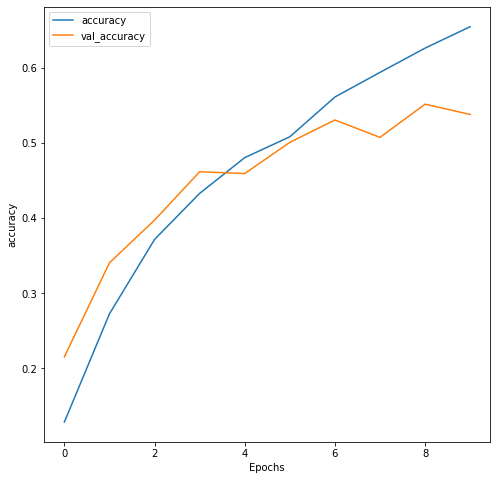

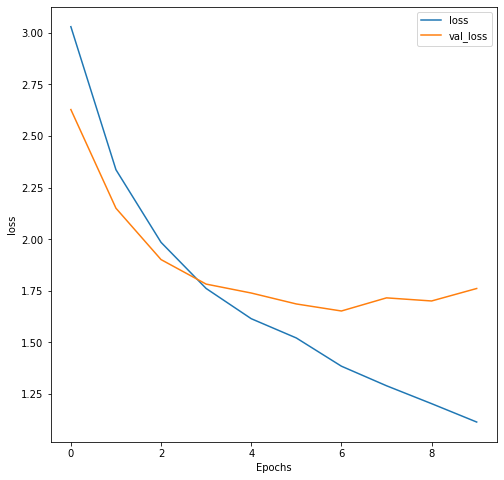

In [185]:
#plotting accuracy and loss curves for train and test set   
plot_graphs(history_raw_text, "accuracy")
plot_graphs(history_raw_text, "loss")

> The validation loss minimum is reached at the 6th epoch corresponding to an 
accuracy of 0.51. After the 6th epoch the validation accuracy reaches a plateau while the training accuracy continues increasing, thereby indicating an overfit of the training set.

In [186]:
#Class prediction
test_pred = model.predict(X_test)


In [187]:
#From class probabilities to label predictions
y_pred_rnn_raw = np.argmax(test_pred,axis=1)

#From label to prdtypecode
y_pred_rnn_raw_final=y_train.columns[y_pred_rnn_raw].values

In [188]:
#checking the unique categories present in the predicted sample:
pd.Series(y_pred_rnn_raw_final).unique()

array([2585, 2403, 1320, 2583, 1560, 1280,   50, 1140, 1300,   10, 2582,
       1160, 1281, 1920, 2522, 2060, 1302, 2280, 1940, 2705,   60, 2905,
         40, 1301, 2462, 2220])

In [189]:
#Classification report
print(classification_report(y_test.idxmax(axis=1),y_pred_rnn_raw_final))

              precision    recall  f1-score   support

          10       0.07      0.09      0.08       601
          40       0.06      0.00      0.01       475
          50       0.40      0.42      0.41       341
          60       0.57      0.79      0.66       176
        1140       0.32      0.36      0.34       552
        1160       0.38      0.88      0.53       791
        1180       0.00      0.00      0.00       139
        1280       0.43      0.52      0.47       944
        1281       0.26      0.17      0.20       415
        1300       0.87      0.72      0.79      1006
        1301       0.67      0.10      0.18       154
        1302       0.47      0.48      0.47       505
        1320       0.41      0.19      0.26       635
        1560       0.61      0.67      0.64       967
        1920       0.87      0.77      0.82       866
        1940       0.17      0.01      0.01       175
        2060       0.59      0.57      0.58      1060
        2220       0.43    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> From the classification report and the analysis unique categories in the prediction variable (y_pred_rnn_raw_final), we can see that there are some categories (**1180**, **1940**, **2462**) which were not assigned to any product by our model, probably due to the unbalanced distribution of the labels within the dataset which neglects some "minor" categories. Therefore, the same RNN model was applied on the cleaned "**text**" feature first and then an oversampling of the dataset was carried out in order to balance the labels distribution within the dataset and again the same RNN model was applied.

In [190]:


#precision tp / (tp + fp)
precision = precision_score(y_test.idxmax(axis=1),y_pred_rnn_raw_final,average="weighted")

#recall: tp / (tp + fn)
recall = recall_score(y_test.idxmax(axis=1),y_pred_rnn_raw_final,average="weighted")

#f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.idxmax(axis=1),y_pred_rnn_raw_final,average="weighted")

#accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.idxmax(axis=1),y_pred_rnn_raw_final)

#updating metrics dictionary
metrics_dic["RNN_raw_text"] = [precision,recall,f1,accuracy]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RNN fitting on the clean "text"
---
The same RNN architecture described in the previous paragraph has been trained on a preprocessed training set cleaned of punctuations, html characters, tags and stopwords

In [100]:
#copy of the orignal dataframe into a df3 new one
df3 = df.copy()

#joining "designation" and "description" variables into "text" and lowercase
df3["text"] = df3["designation"].fillna("").astype("str") + ". "+ df3["description"].fillna("").astype("str") 
df3["text"]=df3["text"].astype(str).str.lower()

#removing tags and html characters
df3['text_no_html']=df3['text'].apply(lambda x : remove_tags(x))
df3['text_no_html']=df3['text_no_html'].apply(lambda x : remove_html_code(x))

#tokenization of the variable "text_no_html"
regexp = RegexpTokenizer('\w+')
df3['text_token']=df3['text_no_html'].apply(regexp.tokenize)

#delete english,french and german stopwords
stop_words_ge = set(stopwords.words("german"))
stop_words_fr = set(stopwords.words("french"))
stop_words_en = set(stopwords.words("english"))
stop_words = set.union(stop_words_en,stop_words_fr,stop_words_ge)
stop_words.update("nan")
df3["text_token"] = df3["text_token"].apply(lambda x: [item for item in x if item not in stop_words])
df3['text_no_stopwords'] = df3['text_token'].apply(lambda x:' '.join([word for word in x if len(word) > 2]))

In [31]:
#applying the preprocessing function to create a vectorized "text" feature
tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,y_train,y_test = preprocessing(df3["text_no_stopwords"],target,tokenizer)

In [32]:
# RNN model building 
embedding_dim = 200

model = Sequential()
model.add(Embedding(50000, embedding_dim)) #
model.add(RNN(GRUCell(128),return_sequences=True)) #comment
model.add(Dropout(0.3)) #comment
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(27, activation='softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         10000000  
                                                                 
 rnn_1 (RNN)                 (None, None, 128)         126720    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
history_clean_text_b256 = model.fit(X_train, y_train.values,batch_size = 256,epochs=10,validation_split=0.2)

with open(model_savepath+"RNN_on_cleaned_text_b256.pkl", 'wb') as f:
    pickle.dump(model, f)


Epoch 1/10
213/213 [==============================] - 453s 2s/step - loss: 3.0199 - accuracy: 0.1322 - val_loss: 2.5289 - val_accuracy: 0.2676
Epoch 2/10
213/213 [==============================] - 437s 2s/step - loss: 2.2314 - accuracy: 0.3056 - val_loss: 2.0287 - val_accuracy: 0.3762
Epoch 3/10
213/213 [==============================] - 444s 2s/step - loss: 1.8775 - accuracy: 0.4143 - val_loss: 1.8137 - val_accuracy: 0.4335
Epoch 4/10
213/213 [==============================] - 448s 2s/step - loss: 1.6694 - accuracy: 0.4763 - val_loss: 1.7465 - val_accuracy: 0.4689
Epoch 5/10
213/213 [==============================] - 443s 2s/step - loss: 1.4924 - accuracy: 0.5310 - val_loss: 1.6460 - val_accuracy: 0.5159
Epoch 6/10
213/213 [==============================] - 444s 2s/step - loss: 1.3281 - accuracy: 0.5852 - val_loss: 1.6106 - val_accuracy: 0.5210
Epoch 7/10
213/213 [==============================] - 447s 2s/step - loss: 1.2109 - accuracy: 0.6191 - val_loss: 1.5782 - val_accuracy: 0.5622

## Model performance analysis
This subsection presents an in-depth analysis of the performances of the trained model in terms of different evaluation metrics

In [ ]:
# with open(model_savepath+"RNN_on_cleaned_text_b256.pkl", 'rb') as f:
#      model = pickle.load(f)

In [35]:
#evaluating accuracy on the train and test sets
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.726, Test: 0.616


In [ ]:
#plotting accuracy and loss curves for train and test set   
plot_graphs(history_clean_text_b256, "accuracy")
plot_graphs(history_clean_text_b256, "loss")

>- The validation loss minimum is reached at the 8th epoch corresponding to an 
accuracy of 0.59. After the 8th epoch the validation accuracy reaches a plateau while the training accuracy continues increasing, thereby indicating an overfit of the training set.

In [37]:
#Class prediction
test_pred = model.predict(X_test)

#From class probabilities to class labels
y_pred_rnn_clean_b256 = np.argmax(test_pred,axis=1)

#From labels to prdtypecode
y_pred_rnn_clean_b256_final=y_train.columns[y_pred_rnn_clean_b256].values

In [ ]:
pd.Series(y_pred_rnn_clean_b256_final).unique()

In [39]:
# Metrics evaluation: accuracy, precision, recall f1-score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,classification_report

#Classification report
print(classification_report(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_final))

              precision    recall  f1-score   support

          10       0.26      0.41      0.32       601
          40       0.24      0.22      0.23       475
          50       0.46      0.19      0.27       341
          60       0.61      0.73      0.66       176
        1140       0.25      0.71      0.36       552
        1160       0.60      0.58      0.59       791
        1180       0.00      0.00      0.00       139
        1280       0.56      0.52      0.54       944
        1281       0.33      0.15      0.21       415
        1300       0.95      0.69      0.80      1006
        1301       0.79      0.59      0.68       154
        1302       0.72      0.57      0.63       505
        1320       0.33      0.62      0.43       635
        1560       0.64      0.80      0.71       967
        1920       0.88      0.81      0.84       866
        1940       0.50      0.32      0.39       175
        2060       0.76      0.65      0.70      1060
        2220       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.26      0.41      0.32       601
          40       0.24      0.22      0.23       475
          50       0.46      0.19      0.27       341
          60       0.61      0.73      0.66       176
        1140       0.25      0.71      0.36       552
        1160       0.60      0.58      0.59       791
        1180       0.00      0.00      0.00       139
        1280       0.56      0.52      0.54       944
        1281       0.33      0.15      0.21       415
        1300       0.95      0.69      0.80      1006
        1301       0.79      0.59      0.68       154
        1302       0.72      0.57      0.63       505
        1320       0.33      0.62      0.43       635
        1560       0.64      0.80      0.71       967
        1920       0.88      0.81      0.84       866
        1940       0.50      0.32      0.39       175
        2060       0.76      0.65      0.70      1060
        2220       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- As for the previous test performed on the raw "text" feature of the dataframe, also in this case the model completely neglect some categories during classification in particular the **1180** **prdtypecode** category. Therefore a oversampling procedure has been performed in order to equilibrate the prdtypecode distribution within the dataframe

In [40]:
#precision tp / (tp + fp)
precision = precision_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_final,average="weighted")

#recall: tp / (tp + fn)
recall = recall_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_final,average="weighted")

#f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_final,average="weighted")

#accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_final)

#updating metrics dictionary
metrics_dic["RNN_clean_text"] = [precision,recall,f1,accuracy]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'RNN_clean_text': [0.6557781395665607,
  0.615814884597268,
  0.6197633271575035,
  0.615814884597268],
 'RNN_clean_text_b256_ros': [0.7333452707029687,
  0.714967027790862,
  0.7184679158669596,
  0.714967027790862]}

## RNN fitting on cleaned text: Random over-sampling
---
In this subsection the RNN model is fitted on the preprocessed "text" variable of the dataset subjected to an oversampling procedure to equilibrate the distribution of the target variable in the dataset

In [13]:
#target variable distribution
y_train.idxmax(axis=1).value_counts(normalize=True)

2583    0.120179
1560    0.060443
1300    0.059457
2522    0.058824
2060    0.057896
1280    0.057793
2280    0.055879
2403    0.055865
1920    0.050595
1160    0.046547
1320    0.038362
10      0.037022
2705    0.032753
1140    0.031193
2582    0.030398
40      0.029927
1302    0.029235
2585    0.028985
1281    0.024363
50      0.019726
2462    0.016531
2905    0.010407
2220    0.009907
60      0.009657
1301    0.009613
1940    0.009245
1180    0.009200
dtype: float64

In [14]:
ros = RandomOverSampler()

#creating a new oversampled train set
X_ros,y_ros = ros.fit_resample(X_train,y_train.idxmax(axis=1))

- Checking shape of the train set and distribution of the target variable

In [15]:
X_ros.shape

(220428, 1084)

Text(0.5, 1.0, 'prdtypecode distribution in the train set before ROS')

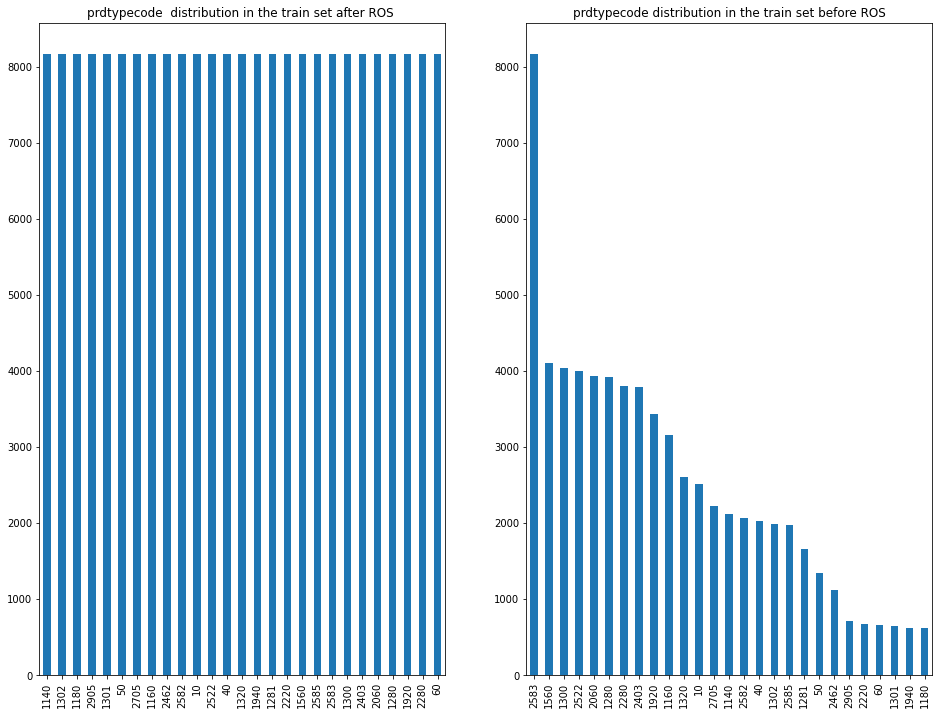

In [16]:
#oversampled target variable distribution
figure,ax = plt.subplots(1,2,figsize=(16,12))

y_ros.value_counts().plot.bar(ax=ax.flat[0])
ax.flat[0].set_title("prdtypecode  distribution in the train set after ROS ")
y_train.idxmax(axis=1).value_counts().plot.bar(ax=ax.flat[1])
ax.flat[1].set_title("prdtypecode distribution in the train set before ROS")

In [17]:
#one hot encoding target variable
y_ros = pd.get_dummies(y_ros)

In [18]:
# RNN model building 
embedding_dim = 200

model = Sequential()
model.add(Embedding(50000, embedding_dim)) #
model.add(RNN(GRUCell(128),return_sequences=True)) #comment
model.add(Dropout(0.3)) #comment
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(27, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         10000000  
                                                                 
 rnn (RNN)                   (None, None, 128)         126720    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:

history_clean_text_b256_ros = model.fit(X_ros, y_ros.values,batch_size = 256,epochs=10,validation_split=0.2)

with open(model_savepath+"RNN_on_cleaned_text_b256_ros.pkl", 'wb') as f:
    pickle.dump(model, f)

Epoch 1/10
689/689 [==============================] - 1417s 2s/step - loss: 2.4791 - accuracy: 0.2308 - val_loss: 2.9948 - val_accuracy: 0.0860
Epoch 2/10
689/689 [==============================] - 1445s 2s/step - loss: 1.4808 - accuracy: 0.5467 - val_loss: 2.0227 - val_accuracy: 0.3326
Epoch 3/10
689/689 [==============================] - 1403s 2s/step - loss: 1.0275 - accuracy: 0.7045 - val_loss: 1.5719 - val_accuracy: 0.4958
Epoch 4/10
689/689 [==============================] - 1411s 2s/step - loss: 0.7597 - accuracy: 0.7899 - val_loss: 1.2810 - val_accuracy: 0.5543
Epoch 5/10
689/689 [==============================] - 1436s 2s/step - loss: 0.5866 - accuracy: 0.8406 - val_loss: 1.0607 - val_accuracy: 0.6057
Epoch 6/10
689/689 [==============================] - 1417s 2s/step - loss: 0.4730 - accuracy: 0.8734 - val_loss: 0.9581 - val_accuracy: 0.6433
Epoch 7/10
689/689 [==============================] - 1402s 2s/step - loss: 0.3880 - accuracy: 0.9001 - val_loss: 0.7557 - val_accuracy:

In [ ]:
# with open(model_savepath+"RNN_on_cleaned_text_b256_ros.pkl", 'rb') as f:
#      model = pickle.load(f)

## Model performance analysis
This subsection presents an in-depth analysis of the performances of the trained model in terms of different evaluation metrics

In [22]:
#evaluating accuracy on the train and test sets
_, train_acc = model.evaluate(X_ros, y_ros, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.925, Test: 0.715


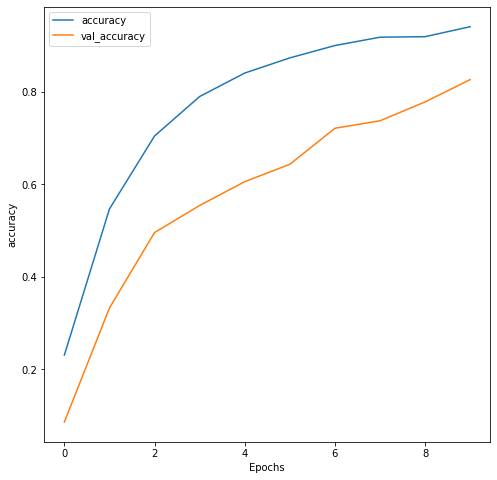

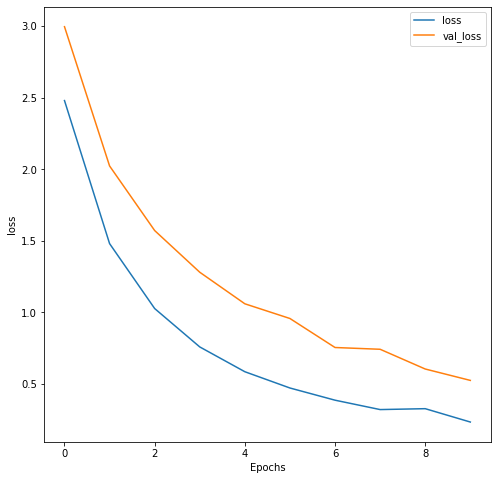

In [21]:
#plotting accuracy and loss curves for train and test set   
plot_graphs(history_clean_text_b256_ros, "accuracy")
plot_graphs(history_clean_text_b256_ros, "loss")

>After 10 epochs the validation accuracy is about 0.83 and the loss validation curve did not attain its minimum yet. However the high validation score is due to a large overfit of the training set as a consequence of the random over sampling, which is also confirmed by the distance between the validation and training curves and by the score obtained on the test set which is about 0.71.


In [23]:
#Class prediction
test_pred = model.predict(X_test)

#From class probabilities to class labels
y_pred_rnn_clean_b256_ros = np.argmax(test_pred,axis=1)

#From labels to prdtypecode
y_pred_rnn_clean_b256_ros_final=y_ros.columns[y_pred_rnn_clean_b256_ros].values

In [25]:
pd.Series(y_pred_rnn_clean_b256_ros_final).unique()

array([2582,   10, 1320, 2583, 1560, 2585,   50, 1940, 1280, 1140, 1300,
       2462,   40, 2522, 2220, 2060, 1302, 1920, 1160, 2280,   60, 1301,
       2403, 1180, 2705, 1281, 2905])

In [27]:
# Metrics evaluation: accuracy, precision, recall f1-score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,classification_report

#Classification report
print(classification_report(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final))

              precision    recall  f1-score   support

          10       0.33      0.31      0.32       601
          40       0.35      0.59      0.44       475
          50       0.70      0.72      0.71       341
          60       0.68      0.86      0.76       176
        1140       0.73      0.60      0.66       552
        1160       0.88      0.79      0.83       791
        1180       0.19      0.63      0.29       139
        1280       0.65      0.57      0.60       944
        1281       0.41      0.46      0.43       415
        1300       0.94      0.89      0.91      1006
        1301       0.92      0.90      0.91       154
        1302       0.76      0.76      0.76       505
        1320       0.64      0.66      0.65       635
        1560       0.72      0.76      0.74       967
        1920       0.86      0.91      0.88       866
        1940       0.76      0.66      0.71       175
        2060       0.80      0.67      0.73      1060
        2220       0.72    

> The classification report shows that by fitting the model on the oversampled training set, all the categories have been predicted (there is no category with zero values in the classification report). However, the prdtypecode 10 ("livres scolaires, guides, biographies"), 40 ("jeux vintage"), 1180 ("fantasy et horror") and 1281 ("jeux de société pour enfants") having very low values of precison and recall. 

In [29]:
#Dictionary summarizing all the metrics computer for each tested model


#precision tp / (tp + fp)
precision = precision_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final,average="weighted")

#recall: tp / (tp + fn)
recall = recall_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final,average="weighted")

#f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final,average="weighted")

#accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final)

#updating metrics dictionary
metrics_dic["RNN_clean_text_b256_ros"] = [precision,recall,f1,accuracy]

## RNN fitting on clean "text": batch size influence
---
In this subsection the effect of changing the size of the batch has been investigated on the same RNN model test up to now trained on the cleaned **text** feature

In [ ]:
tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,y_train,y_test = preprocessing(df3["text_no_stopwords"],target,tokenizer)

In [ ]:
# RNN model building 
embedding_dim = 200

model = Sequential()
model.add(Embedding(50000, embedding_dim)) #comment
model.add(RNN(GRUCell(128), return_sequences=True)) #comment
model.add(Dropout(0.3)) #comment
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))

model.summary()



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time
model_savepath =  r"/content/drive/MyDrive/"
begin3 = time.time()
history_clean_text_b128 = model.fit(X_train, y_train.values,batch_size = 128,epochs=10,validation_split=0.2,callbacks=early_stopping)
end3 = time.time()
with open(model_savepath+"RNN_on_cleaned_text_b128.pkl", 'wb') as f:
    pickle.dump(model, f)

## Model performance analysis
This subsection presents an in-depth analysis of the performances of the trained model in terms of different evaluation metrics

In [ ]:
#evaluating accuracy on the train and test sets
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
#plotting accuracy and loss curves for train and test set   
plot_graphs(history_clean_text_b128, "accuracy")
plot_graphs(history_clean_text_b128, "loss")

- The validation loss minimum is reached at the 7th epoch corresponding to an 
accuracy of 0.63. After the 7th epoch the validation accuracy reaches a plateau while the training accuracy continues increasing, thereby indicating an overfit of the training set.

In [ ]:
#Class prediction
test_pred = model.predict(X_test)

#From class probabilities to class labels
y_pred_rnn_clean_b128 = np.argmax(test_pred,axis=1)

#From labels to prdtypecode
y_pred_rnn_clean_b128_final=y_train.columns[y_pred_rnn_clean_b128].values

In [ ]:
# Metrics evaluation: accuracy, precision, recall f1-score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

#Classification report
print(classification_report(y_test.idxmax(axis=1),y_pred_rnn_clean_b128_final))

In [ ]:
#Dictionary summarizing all the metrics computer for each tested model

#precision tp / (tp + fp)
precision = precision_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b128_final,average="weighted")

#recall: tp / (tp + fn)
recall = recall_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b128_final,average="weighted")

#f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b128_final,average="weighted")

#accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.idxmax(axis=1),y_pred_rnn_clean_b128_final)

#updating metrics dictionary
metrics_dic["RNN_clean_text_b128"] = [precision,recall,f1,accuracy]

#  RNN(LSTM) fitting on clean "text"
---
In this section a different rnn architecture has been tested based on a LSTM layer

In [129]:
tokenizer,word2idx,idx2word,vocab_size,X_train,X_test,y_train,y_test = preprocessing(df3["text_no_stopwords"],target)

In [132]:
X_test.shape

(16984, 1026)

 We define a sequential model and add various layers to it:
>1. An Embedding layer representing words using a dense vector representation.
2. An LSTM layer with 128 neurons. 
3. A Dropout layer used for regulating the network and keeping it as away as possible from any bias. 
4. A Global Average Pooling layer.
5. A Dense layer with 256 neurons.
6. A second Dropout layer. 
7. An output Dense layer which has 27 cells representing the 27 different categories, with softmax activation function providing the predictions in terms of probability.

The model has been compiled using **adam optimizer** and **sparse_categorical_crossentropy**.

In [137]:
from tensorflow.keras.layers   import LSTM

embedding_dim = 200

model = Sequential()
model.add(Embedding(50000, embedding_dim)) #comment
model.add(LSTM(128, activation="tanh",return_sequences=True)) #comment
model.add(Dropout(0.3)) #comment
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 200)         10000000  
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         168448    
                                                                 
 dropout_16 (Dropout)        (None, None, 128)         0         
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                      

In [138]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [139]:

history_clean_text_LSTM = model.fit(X_train, y_train.values,batch_size = 256,epochs=10,validation_split=0.2)

with open(model_savepath+"LSTM_on_cleaned_text.pkl", 'wb') as f:
    pickle.dump(model, f)

Epoch 1/10
213/213 [==============================] - 36s 159ms/step - loss: 3.0113 - accuracy: 0.1348 - val_loss: 2.6766 - val_accuracy: 0.2012
Epoch 2/10
213/213 [==============================] - 33s 156ms/step - loss: 2.3661 - accuracy: 0.2750 - val_loss: 2.1900 - val_accuracy: 0.3322
Epoch 3/10
213/213 [==============================] - 33s 156ms/step - loss: 2.0052 - accuracy: 0.3722 - val_loss: 1.9227 - val_accuracy: 0.4049
Epoch 4/10
213/213 [==============================] - 33s 156ms/step - loss: 1.7252 - accuracy: 0.4549 - val_loss: 1.7034 - val_accuracy: 0.4753
Epoch 5/10
213/213 [==============================] - 33s 156ms/step - loss: 1.5059 - accuracy: 0.5216 - val_loss: 1.5810 - val_accuracy: 0.5122
Epoch 6/10
213/213 [==============================] - 33s 156ms/step - loss: 1.3321 - accuracy: 0.5750 - val_loss: 1.4604 - val_accuracy: 0.5565
Epoch 7/10
213/213 [==============================] - 33s 156ms/step - loss: 1.1786 - accuracy: 0.6237 - val_loss: 1.4245 - val_ac

INFO:tensorflow:Assets written to: ram://55b2c57b-9950-41cb-a4ad-b5ede9825f22/assets


INFO:tensorflow:Assets written to: ram://55b2c57b-9950-41cb-a4ad-b5ede9825f22/assets


In [ ]:
# import pickle
# with open(model_savepath+"LSTM_on_cleaned_text.pkl", 'rb') as f:
#      model = pickle.load(f)


## Model performance analysis
This subsection presents an in-depth analysis of the performances of the trained model in terms of different evaluation metrics

In [140]:
#evaluating accuracy on the train and test sets
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.751, Test: 0.650


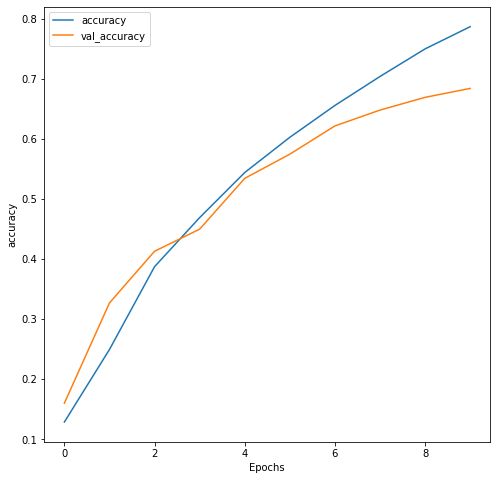

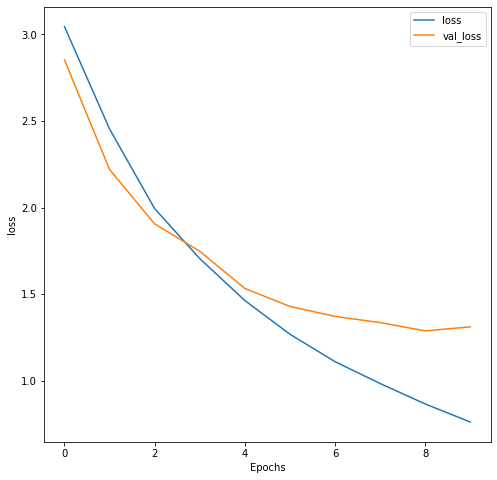

In [70]:
#plotting accuracy and loss curves for train and test set   
plot_graphs(history_clean_text_LSTM, "accuracy")
plot_graphs(history_clean_text_LSTM, "loss")

The validation loss curves minimum is located at the 9th epoch which corresponds to a validation accuracy of about 0.67 in line with the test accuracy score. 

In [65]:
#Class prediction
test_pred = model.predict(X_test)

#From class probabilities to class labels
y_pred_clean_text_lstm = np.argmax(test_pred,axis=1)

In [66]:
#From label to prdtypecode
y_pred_clean_text_lstm_final = y_train.columns[y_pred_clean_text_lstm].values

In [67]:
y_test=y_test.idxmax(axis=1)


In [75]:
#checking the unique categories present in the predicted sample:
pd.Series(y_pred_clean_text_lstm_final).unique()

array([2582, 2280, 1320, 2583, 1560, 1280,   50, 1302, 1140, 1300, 1160,
       2462,   40,   10, 2060, 1920, 2522, 2585, 1301, 2705,   60, 1281,
       2403, 2905, 1940, 2220])

- The category **1180** is completely neglected

In [71]:
# Metrics evaluation: accuracy, precision, recall f1-score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,classification_report

#Classification report
print(classification_report(y_test,y_pred_clean_text_lstm_final))

              precision    recall  f1-score   support

          10       0.26      0.54      0.35       601
          40       0.40      0.31      0.35       475
          50       0.69      0.49      0.57       341
          60       0.80      0.77      0.78       176
        1140       0.42      0.60      0.49       552
        1160       0.73      0.72      0.73       791
        1180       0.00      0.00      0.00       139
        1280       0.56      0.62      0.59       944
        1281       0.41      0.18      0.25       415
        1300       0.83      0.89      0.86      1006
        1301       0.80      0.71      0.75       154
        1302       0.74      0.68      0.70       505
        1320       0.48      0.71      0.57       635
        1560       0.71      0.77      0.74       967
        1920       0.89      0.85      0.87       866
        1940       0.72      0.43      0.54       175
        2060       0.76      0.67      0.71      1060
        2220       0.75    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>The classification report shows a f1 weighted average score of 0.69. However, the model does not keep the same performances throughout the categories. Indeed, we can see that there are some having quite low values of precision and recall as the prdtypecode 10 (“livres scolaires, guides, biographies”), 40(“jeux vintage”) and 1281 (“jeux de société pour enfants”) showing scores values around 0.4 for both precision and recall. Moreover, the category 1180 (“fantasy et horror”) is completely neglected by our model. 

In [72]:
#Dictionary summarizing all the metrics computed for each tested model


#precision tp / (tp + fp)
precision = precision_score(y_test,y_pred_clean_text_lstm_final,average="weighted")

#recall: tp / (tp + fn)
recall = recall_score(y_test,y_pred_clean_text_lstm_final,average="weighted")

#f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_pred_clean_text_lstm_final,average="weighted")

#accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_pred_clean_text_lstm_final)

#updating metrics dictionary
metrics_dic["LSTM_clean_text_b256"] = [precision,recall,f1,accuracy]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Graph Comparison of all tested models

In [191]:
df_plot = pd.DataFrame(metrics_dic)
df_plot.rename(index={0:"precision",1:"recall",2:"f1_score",3:"accuracy"},inplace=True)

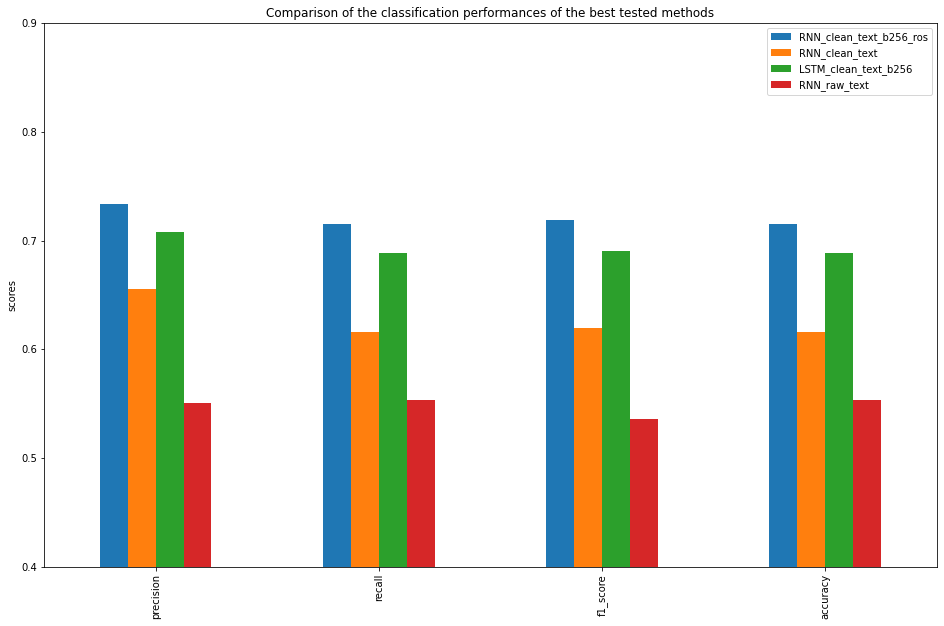

In [193]:
figure,ax = plt.subplots(figsize=(16,10))
plt.title("Comparison of the classification performances of the best tested methods")
plt.ylim(0.4,0.9)
plt.ylabel("scores")
df_plot.plot.bar(ax=ax);

The random over sampling procedure increases of almost 20% the classification performances of the RNN model in terms of all evaluated metrics. Also as we saw above, it is necessary to take into consideration all the prdtypecode categories. In order to go deeper into the results provided by this methodology we analysed the confusion matrix.

### Confusion Matrix
---
The confusion matrix is plotted for the best evaluated methodology: The RNN applied on the random over sampled dataset

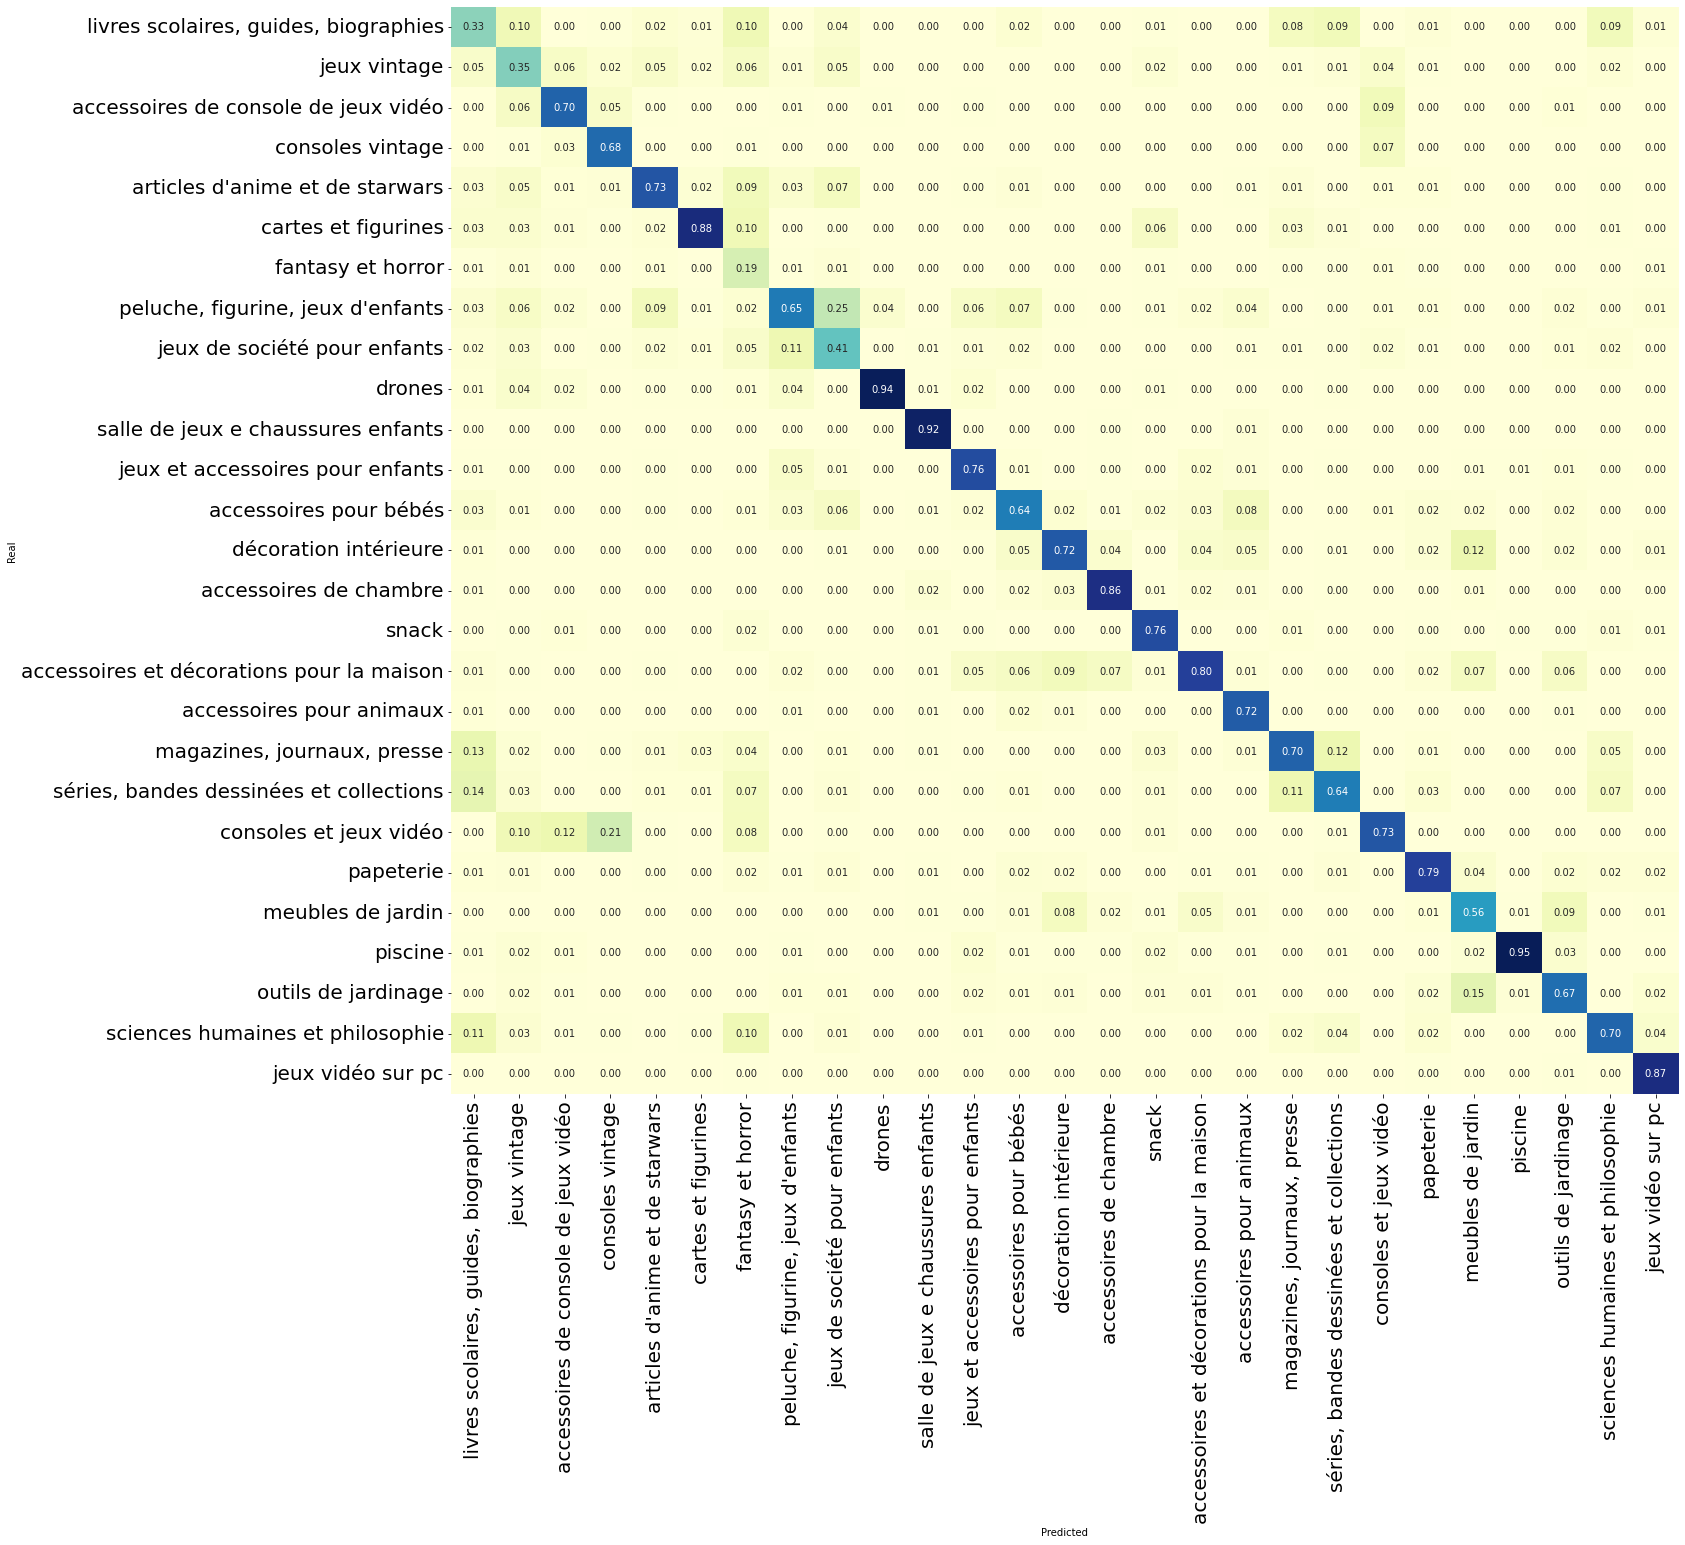

In [194]:
#-----------------------------------------------------------------------------------------------------
#plotting confusion matrix normalized by columns to show along the diagonal the precision of each class
#------------------------------------------------------------------------------------------------------
import seaborn as sns
conf_matrix = pd.crosstab(y_test.idxmax(axis=1),y_pred_rnn_clean_b256_ros_final,rownames=["Real"],colnames=["Predicted"],normalize="columns")
plt.figure(figsize=(22,20))
tick_labels = [j for k,j in sorted(dic.items())]
ax = plt.subplot()
sns.heatmap(conf_matrix, fmt='.2f',annot=True,cmap="YlGnBu", cbar=False,ax=ax)
ax.xaxis.set_ticklabels(tick_labels,rotation=90,fontsize=20);
ax.yaxis.set_ticklabels(tick_labels, rotation=0,fontsize=20);

> The confusion matrix shows that:
1. 40% of the items associated by the model to the prdtypecode 10 ("livres scolaires, guides, biographie") belong in fact to prdtypecode  2280 ('magazines, journaux, presse'),2403('séries, bandes dessinées et collections'), 2705 ('sciences humaines et philosophie')
2. 10% of categories associated by the model to the prdtypecode 40 ("jeux vintage"), in fact belong to 2462('consoles et jeux vidéo')

This indicates that the similarities between the categories is the main source of misclassification and lowering of model scores.